<a href="https://colab.research.google.com/github/idnm/cpflow/blob/master/tutorial/CPFlow_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and imports

1. _If you are running the notebook interactively in colab_: execute the code cell in __Colab setup__ section, then restart runtime and  proceed to the __Imports__ cell and the rest of the notebook. 

1. _If you are running the notebook locally_: skip the __Colab setup__ section and go from __Imports__ on. Make sure that `cpflow` and dependencies are installed.

## Colab setup

This is the key install.

In [ ]:
try:
   import cpflow
except ImportError:
  !pip install cpflow

import os
if not os.path.exists('results'):
    !mkdir results

The following tries to install an optional feature needed for Clifford+T decompositions. Errors here can be ignored.

In [ ]:
try:
   from qiskit.transpiler.passes import SolovayKitaevDecomposition
except ImportError:
  # Install Rust compiler needed to build a wheel for qiskit-terra
  !apt install rustc
  !gdown --id 1PULtTc-2e9z4bswh_SQqL5oy_4JpfV7c
  !chmod +x evcxr_jupyter
  !./evcxr_jupyter --install
  # Install qiskit branch with SolovayKitaevDecomposition
  !pip install git+https://github.com/LNoorl/qiskit-terra@d2e0dc1185ccc3b0c9957e3d7d9bc610dede29d4

  print("Don't forget to restarst the runtime!")

## Imports

In [ ]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator
import numpy as np

from jax import vmap
import jax.numpy as jnp
import matplotlib.pyplot as plt

from cpflow import *

# Background


The main goal of CPFlow is to find quantum circuits consisting of CNOTs+arbitrary 1q gates that simultaneously
- Minimize a given loss function $L(U)$, where $U$ is the unitary of the circuit.
- Do it with as few CNOT gates as possible.

Indirectly the circuits can also be optimized for CNOT depth and even T count or T depth in some cases. Loss function $L(U)$ may correspond to compilation, state preparation or any other task.

CPFlow uses circuits with 2q [controlled phase gates](https://qiskit.org/documentation/stubs/qiskit.circuit.library.CPhaseGate.html), which we call CP templates, to combine the architecture search and parameter optimization into a single coherent continuous optimization. Example of a CP template is shown below.

 (_NOTE: code in this section is for illustration purposes, actual usage examples are found in later sections_.)

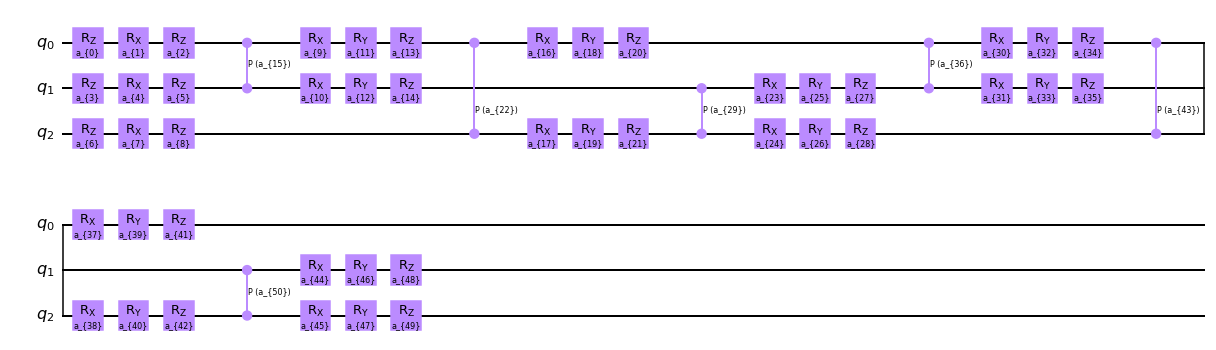

In [ ]:
from cpflow.topology import connected_layer, fill_layers

num_qubits = 3
num_cp_gates = 6
cp_template = Ansatz(num_qubits, 'cp', fill_layers(connected_layer(num_qubits), num_cp_gates))
cp_template.circuit().draw(output='mpl')


Controlled phase gates CP($a$) with $a=0$ are equivalent to identity gates, with $a=\pi$ to CZ gates. CP($a$) with intermediate values of $a$ can be decomposed using 2 CZ gates. Hence, different choices of CP angles in a CP template correspond to different architectures of conventional CZ/CNOT circuits. Changing values of CP angles allows a single CP template to interpolate between different CZ/CNOT circuits. To minimize the CZ count, optimization of the original loss function is performed with an additional regularization term

$$\mathcal{L}(U)=L(U)+r \sum_{a_i\in CP}R(a_i) \ .$$

Here $U$ is the unitary matrix of the CP template, $L(U)$ is the original loss function, $r$ is the overall weight of the regularization term. The sum in regularization term is over all CP angles, penalty function $R(a)$ for a single CP gate has the following shape:

Text(0.5, 0, 'Angle of CP gate $a$')

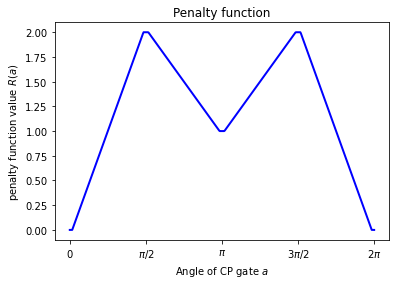

In [ ]:
from cpflow.cp_utils import make_regularization_function
from cpflow.main import RegularizationOptions

penalty_func = make_regularization_function(RegularizationOptions)
a_sweep = jnp.linspace(0, 2*jnp.pi, 500)
plt.plot(a_sweep, vmap(penalty_func)(a_sweep), 'blue', linewidth=2)
plt.xticks([0, jnp.pi/2, jnp.pi, 3*jnp.pi/2, 2*jnp.pi], ['$0$', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])
plt.title('Penalty function')
plt.ylabel('penalty function value $R(a)$')
plt.xlabel('Angle of CP gate $a$')

This regularization function is intended to drive all CP angles to either 0 or $\pi$, and effectively reduce the CP circuit to the CZ circuit minimizing the number of CZ gates. Both the regularization term and the original loss function typically have many local minumums. CPFlow takes a straightfoward approach of an extensive multi-start optimization to mitigate the problem. There are two basic synthesis routines:
- Static: optimization with a fixed CP template and regularization weight $r$.
- Adaptive: repetitive rounds of static synthesis with hyperparameters (the number of CP gates and the value of $r$) tuned by the [Hyperopt algorithm](http://hyperopt.github.io/hyperopt/) .


The rest of the notebook containes several examples of using both routines as well as some additional features.

_NOTE: If you are running the notebook interactively all code cells in each major section must be executed sequentially. Different sections do not share variables and can be executed independently._

# Static synthesis example: 3q Toffoli gate

## Defining the target unitary


We will now use CPFlow to find efficient decomposisions of the 3q Toffoli gate on the nearest-neighbor topology. One can input the unitary matrix directly, but we will import it from `qiskit`.


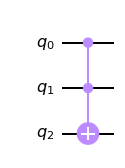

In [ ]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
u_toff3 = Operator(qc.reverse_bits()).data
qc.draw(output='mpl')

Note that CPFlow does not follow the little-endian convention of `qiskit` so we applied the `reverse_bits()` method before extracting the unitary. 

## Setting up the decomposer

The following lines initialize the decomposer.

In [ ]:
layer = [[0, 1], [1, 2]]  # Layer corresponding to the linearly connected qubit topology 0-1-2.
decomposer = Synthesize(layer, target_unitary=u_toff3, label='toff3_chain')
options = StaticOptions(
    num_cp_gates=14, 
    r=0.00055,
    accepted_num_cz_gates=20,
    num_samples=4,
    )

- The main role of `layer` is to provide the information about the qubit connectivity -- the final decompositions can only contain entangling gates between qubit pairs specified in `layer`.  The order of qubits in each pair does not matter, the order of pairs and presence of duplicates in `layer` matters in theory but rarely in practice. The simplest way to construct layers is to just list (in arbitrary order) all pairs of qubits that admit entangling gates.
- `label` is a name/short description to keep track of what we are decomposing (referencing the unitary matrix itself is often not helpful). It is also used to name the file on a disk that stores the results of the synthesis.
- `options` specify exact details of template construction, optimization, and verification. The only required attributes are `num_cp_gates` -- the total number of entagling gates in the template (together with `layer` this specifies the template completely) and `accepted_num_cz_gates` -- only decompositions with CZ count below this value will be verified and stored. Additionaly, we provided the value of the regularization weight (same as default, just to emphasize it is there) and chose a small number of samples for multistart optimization `num_samples`, which is sufficient in this case.

## Running the decomposer



We can now run the decomposer.

In [ ]:
results = decomposer.static(options)


Starting decomposition routine with the following options:

 StaticOptions(num_samples=4, method='adam', learning_rate=0.1, num_gd_iterations=2000, cp_distribution='uniform', entry_loss=0.001, target_loss=1e-06, threshold_cp=0.2, learning_rate_at_verification=0.01, num_gd_iterations_at_verification=5000, random_seed=0, rotation_gates='xyz', num_cp_gates=14, r=0.00055, accepted_num_cz_gates=20)

Computing raw results...

Selecting prospective results...

Found 4. Verifying...


  0%|          | 0/4 [00:00<?, ?it/s]


4 successful. cz counts are:
[8, 9, 14, 15]


## Analyzing decompositions

Four decompositions with CZ count below the specified threshold were found. They are stored in `decompositoins` attribute of `results`.

In [ ]:
results.decompositions

[< toff3_chain| Approximate | loss: 2.384185791015625e-07  | CZ count: 8 | CZ depth: 8  >,
 < toff3_chain| Approximate | loss: 0.0  | CZ count: 9 | CZ depth: 9  >,
 < toff3_chain| Approximate | loss: 0.0  | CZ count: 14 | CZ depth: 14  >,
 < toff3_chain| Approximate | loss: 0.0  | CZ count: 15 | CZ depth: 15  >]

Let us take a closer look at the first decomposition with the best CZ count.

< toff3_chain| Approximate | loss: 2.384185791015625e-07  | CZ count: 8 | CZ depth: 8  >


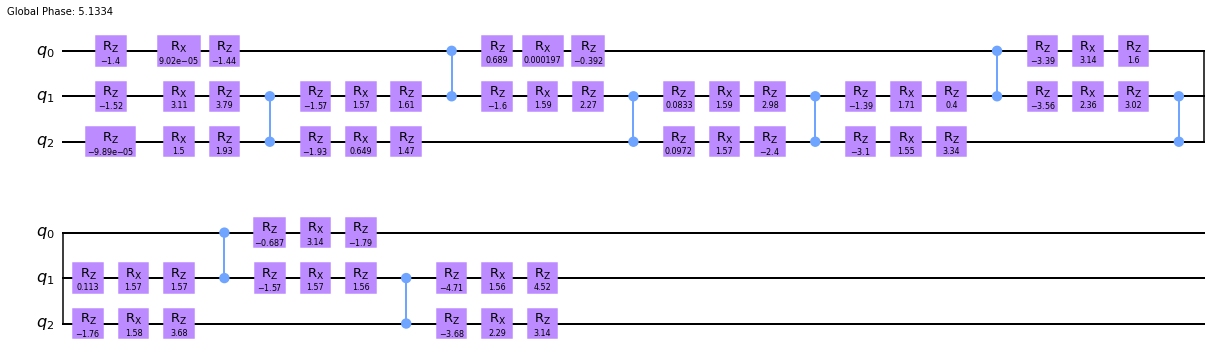

In [ ]:
d = results.decompositions[0]
print(d)
d.circuit.draw(output='mpl')

We can see explicitly that this circuit complies with the linear connectivity and has 8 CZ gates. The `loss` value here is the Hilbert-Schmidt distance to the target unitary and is zero within the machine precision. `Approximate` means that the decomposition is a raw result of numerical optimization. A careful look at the circuit suggests that some of the 1q gates can be simplified or removed. CPFlow has an experimental automated routine to do this.

In [ ]:
d.refine()

'Refined to Clifford+T'

In this case the routine was able to find an exact version of the circuit and decompose it into a Clifford+T basis. This is reflected in a new description of the circuit which now also features T count and T depth. This can also be checked by looking at the new circuit diagram (rotation gates with angles $\pi/4$ are non-clifford).

< toff3_chain| Clifford+T | loss: 2.384185791015625e-07  | CZ count: 8 | CZ depth: 8  | T count: 7 | T depth: 4 >


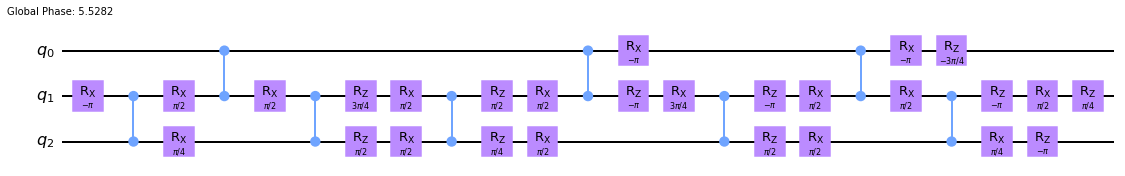

In [ ]:
print(d)
d.circuit.draw(output='mpl')

Note that as of yet `refine` method behaves quite irregularly ond often fails to find efficient simplifications. Generating many decompositions and applying `refine` to each of them can somethimes help.

## Saving and loading results

The results are __automatically__ saved if you prodived a label with your decomposition. The default location is `results/label` but it can be ovewritten by providing `save_to` path in the decomposer call `decomposer.static(options, save_to=path)`. Note: if you've applied `refine` method to some of the decompositions the refined results are not saved by default. To save them, execute

In [ ]:
results.save()

Existing results can be loaded as follows.

In [ ]:
del results  # we delete the variable just to emphasize that results are loaded from the disk.
results = Results.load('results/toff3_chain')
results.decompositions

[< toff3_chain| Clifford+T | loss: 2.384185791015625e-07  | CZ count: 8 | CZ depth: 8  | T count: 7 | T depth: 4 >,
 < toff3_chain| Approximate | loss: 0.0  | CZ count: 9 | CZ depth: 9  >,
 < toff3_chain| Approximate | loss: 0.0  | CZ count: 14 | CZ depth: 14  >,
 < toff3_chain| Approximate | loss: 0.0  | CZ count: 15 | CZ depth: 15  >]

# Adaptive synthesis example: 4q Toffoli gate

## Hyperparameters

The static routine that we used above has several hyperparameters that can significantly alter the results. Two of the most crucial appear to be the number of gates in a CP template and the regularization weight $r$. Adaptive routine uses Hyperopt's algorithm to tune these hyperparameters and stores interesting decompositions found along the way. We will illustrate the adaptive routine with the 4q Toffoli gate on a 'star'-shaped topology. 

## Defining the target unitary

Again, we will define the target unitary using `qiskit`.

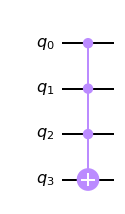

In [ ]:
qc = QuantumCircuit(4)
qc.mct([0, 1, 2], 3)
u_toff4 = Operator(qc.reverse_bits()).data
qc.draw(output='mpl')

## Setting up the decomposer

Decomposer is set up in a very similar manner to the static case, except that now options must be an instance of the `AdaptiveOptions` class.

In [ ]:
layer = [[0, 1], [0, 2], [0, 3]]  # 'Star' or 'T-shaped' layer where qubits 1,2,3 are only connected to qubit 0.
decomposer = Synthesize(layer, target_unitary=u_toff4, label='toff4_star')
options = AdaptiveOptions(
    min_num_cp_gates=10,
    max_num_cp_gates=30,
    r_mean=0.0005,  # Default value, speficied explicitly only for illustration.
    r_variance=0.5,  # Default value, speficied explicitly only for illustration.
    num_samples=500,
    max_evals=5
)

Here `layer` again is intended to indicate the qubit connectivity. Adaptive options have only two required attributes: `min_num_cp_gates` and `max_num_cp_gates` specifying the allowed range for CP templates during the hyperparameter tuning. The second hyperparameter that is optimized is the regularization weight $r$ sampled from the lognormal distribution with mean `r_mean` and variance `r_variance`. We have explicitly set these parameters to their default values to emphasize that they are present. `max_evals` determines the total number of hyperparameter evaluations.`num_samples` determines how many initial conditions are used for multi-start optimization at each hyperparmeter configuration. Empirically we find that a suitable number of samples grows rapidly (likely exponentially) as the expected number of gates in the compiled circuit increases. 

## Running the decomposer

Now that the setup is in place we can run the decomposer. The code below should take several minutes to run.

In [ ]:
results = decomposer.adaptive(options)


Starting decomposition routine with the following options:

 AdaptiveOptions(num_samples=500, method='adam', learning_rate=0.1, num_gd_iterations=2000, cp_distribution='uniform', entry_loss=0.001, target_loss=1e-06, threshold_cp=0.2, learning_rate_at_verification=0.01, num_gd_iterations_at_verification=5000, random_seed=0, rotation_gates='xyz', min_num_cp_gates=10, max_num_cp_gates=30, r_mean=0.0005, r_variance=0.5, max_evals=5, target_num_cz_gates=0, stop_if_target_reached=False, keep_logs=False)


Evaluations:   0%|          | 0/5 [00:00<?, ?it/s]


------------------------------------------
iteration 0/5

num_cp_gates: 18, r: 0.0005069511389752133
score: inf, cz counts of prospective results: []

Found no decompositions potentially improving the current best count 61.

------------------------------------------
iteration 1/5

num_cp_gates: 18, r: 0.00042233662661280336
score: inf, cz counts of prospective results: []

Found no decompositions potentially improving the current best count 61.

------------------------------------------
iteration 2/5

num_cp_gates: 18, r: 0.0005889875866486171
score: inf, cz counts of prospective results: []

Found no decompositions potentially improving the current best count 61.

------------------------------------------
iteration 3/5

num_cp_gates: 11, r: 0.0019248510669024055
score: inf, cz counts of prospective results: []

Found no decompositions potentially improving the current best count 61.

------------------------------------------
iteration 4/5

num_cp_gates: 27, r: 0.00088169516980888

The first four iterations yilded no decompositions (most likely `num_cp_gates` was too low) while the fifth evaluation found many prospective decompositions and confirmed a decomposition with 18 gates. Note that only decompositions that improve the current best are verified and stored during the adaptive routine. Let us take a look at the decomposition found.

< toff4_star| Approximate | loss: 0.0  | CZ count: 18 | CZ depth: 18  >


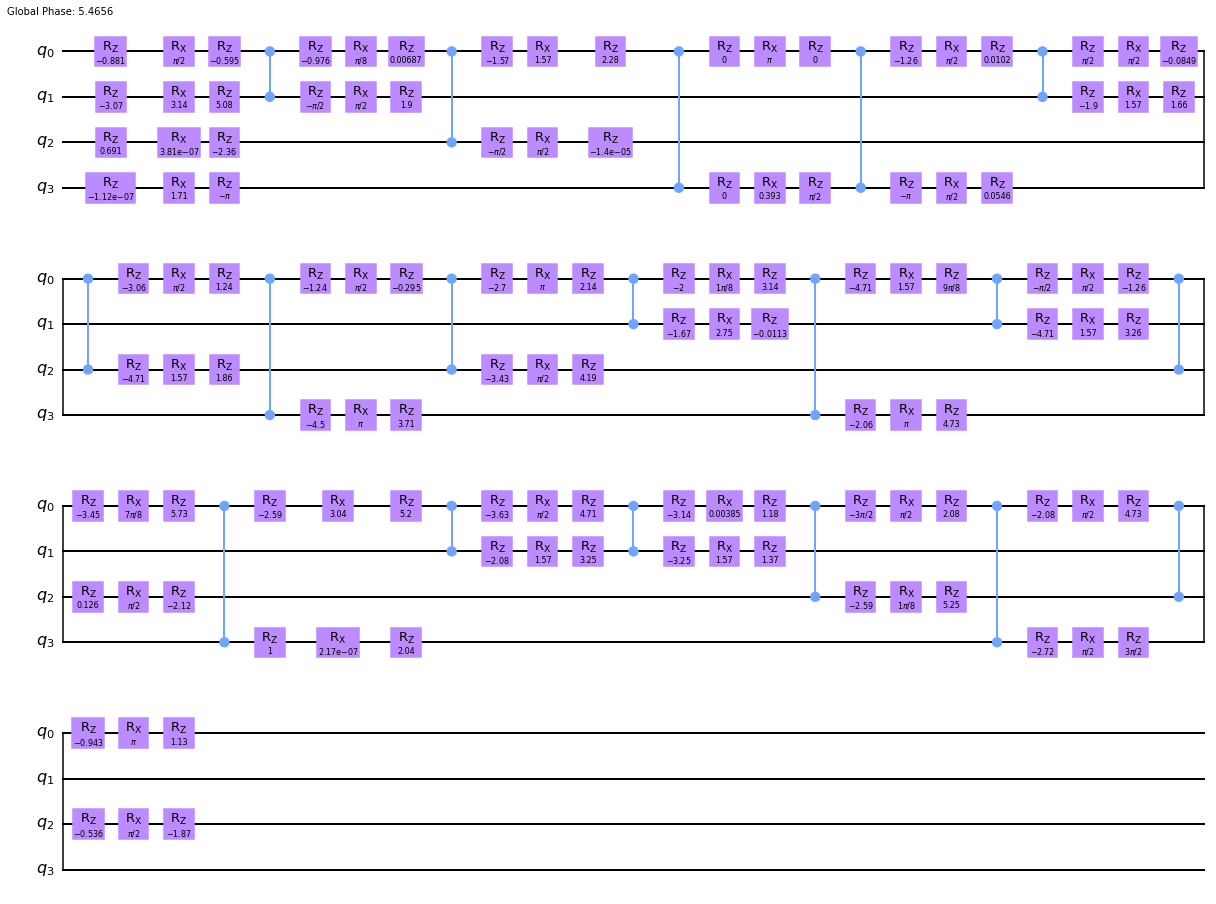

In [ ]:
d = results.decompositions[-1]
print(d)
d.circuit.draw(output='mpl')

We can see explicitly from the circuit that it complies with the topological restrictions (all two-qubit gates start at qubit 0). The best decomposition of the 4q Toffoli gate on the star topology that we know of has 16 CZ gates. To keep searching for better results we can just change the number of `max_evals` and run the synthesis again. The existing evaluations are automatically taken into account and the process continues with the next evaluation.

_NOTE 1: first 20 hyperparameter evaluations are random and inteded to sample broadly from the search space. Actual optimization starts after that. If `num_samples` is sifficiently large to accurately evaluate the quality of hyperparameters (which is a stochastic function) convergence could be expected near a 100 evaluations. However, near-optimal or optimal decompositions are likely to be found much earlier. As we saw, a near-optimal 18 CZ decomposition was found during the first 5 evaluations._

_NOTE 2: the code below takes a couple of hours to run on a standard Colab GPU. If you are running this interactively you can skip the following cell and continue to the next, which loads the precomputed results. If you have already started the next sell you can simply abort evaluation._


In [ ]:
options.max_evals = 50

### Uncomment the next line if you want to reproduce results locally.
# results = decomposer.adaptive(options)

If the evaluation takes too long or you have obtained the desired ouput before reaching `max_evals` you can simply abort the calculation and intermediate results won't be lost (even if the variable `results` is missing). The same is true if you were disconnected from a server or execution broke for any other reason. After each evaluation results are saved to a disk (default location is `results/label`). Existing results are loaded as before.

In [ ]:
# Comment out the next line if you have local results and want to use them instead.
!wget -q -O results/toff4_star https://github.com/idnm/cpflow/raw/master/tutorial/results/toff4_star 

results = Results.load('results/toff4_star')

A new decomposition with 16 CZ gates was found during further search. By the way, to the best of our knowledge this improves by 1 gate on the known most efficient decomposition on the star topology (cf. [ref](https://arxiv.org/abs/2109.13223)).

In [ ]:
results.decompositions

[< toff4_star| Approximate | loss: 0.0  | CZ count: 18 | CZ depth: 18  >,
 < toff4_star| Approximate | loss: 0.0  | CZ count: 17 | CZ depth: 17  >,
 < toff4_star| Approximate | loss: 0.0  | CZ count: 16 | CZ depth: 16  >]

One can now process this decomposition in any of the usual ways, draw the circuit, export the qasm description etc. The `circuit` attribute returns the `qiskit` circuit of the decomposition.

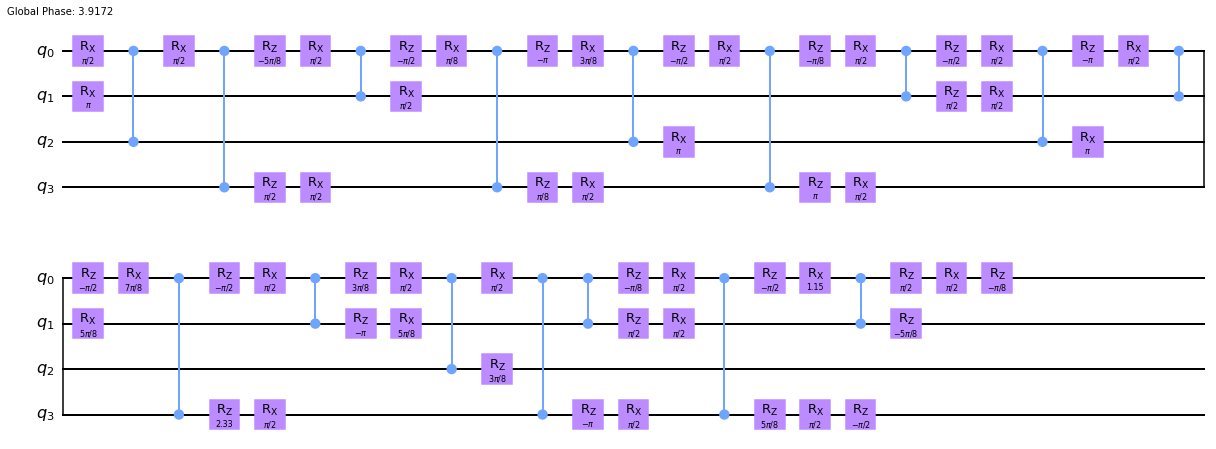

In [ ]:
d = results.decompositions[-1]
d.refine()
qiskit_circuit = d.circuit
# print(qiskit_circuit.qasm()) # Uncomment to get a qasm description.
qiskit_circuit.draw(output='mpl')

## Visualizing trials

It may be instructive to take a look at how different hyperparameter configurations compare to each other. This can be done using `plot_trials` method.

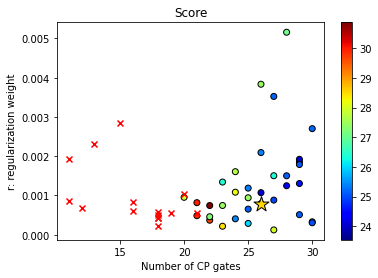

In [ ]:
results.plot_trials()

Here score is the objective function optimized by the Hyperopt. In CPFlow it is defined (rather arbitrarily) as 

$$score=-\log_2\frac{1}{N}\sum_{i}2^{-k_i}, $$

where the sum is over all prospective decompositions found during a given trial, $k_i$ are CZ counts of the respective decompositoins, and $N=$ `num_samples` is the total number of initial conditions tried. This function is reminiscent of softmin and the motivation behind the definition is to give heavier weights to the most optimal decompositions while not ignoring completely less efficient ones. Generally, lower score values correspond to better hyperparameter configurations, though the best decompositoins are often found at suboptimal (according to this metric) points. Red crosses at the figure correspond to the infinite score values, where no valid decompositions were found. The gold star marks the lowest score value.

To list all hyperparameter configurations tried (in order of increasing score) call:

In [ ]:
# Return pairs [num_cp_gates, r] in order of increasing score value.
print(results.best_hyperparameters())

[[26, 0.0007929647119771891], [29, 0.001921245015542859], [26, 0.001070845320385551], [28, 0.001247417954425284], [29, 0.0013044046502647495], [27, 0.0008816951698088887], [30, 0.0003039227939242174], [29, 0.001788249625815759], [29, 0.0005103573071343607], [25, 0.0006518634523591494], [28, 0.0015011547631050394], [30, 0.0027021869924218666], [27, 0.003523320152327195], [30, 0.00032770573164276956], [26, 0.0020929496757183977], [25, 0.0011866360100009831], [24, 0.00040459807684166497], [29, 0.0018546538582270118], [25, 0.00028744775140944457], [27, 0.001502187577073108], [23, 0.0013416417686510941], [28, 0.005158794184022685], [22, 0.0004570914006232872], [23, 0.0007445601460957848], [26, 0.0038340735130554344], [25, 0.0009406654911617926], [24, 0.0016057043479854617], [27, 0.00012165627976087087], [20, 0.0009523613581472433], [24, 0.0010831384788901016], [23, 0.00021519531169415438], [22, 0.0003687679260635769], [21, 0.0004839330827185172], [21, 0.0008162760956025106], [22, 0.00074330

Looking at the visualization above we see that not all point near the best configuration have low score values. This is an artefact of the score function being stochastic and is likely to imporove if more samples are used to evaluate hyperparameters. This however was not an obstacle to find (apparently) the most optimal decomposition that exists. In the end, evaluation of hyperparameters is only a means to finding good decompositions.

# Using custom loss functions: state preparation and relative phase Toffoli gate

## Hilbert-Schmidt distance

The loss function that was implicitly used in all of the above examples is the Hilbert-Schmidt distance between unitary matrices defined as
$$D(U,V)=1-\frac{|\operatorname{Tr}U^\dagger V|^2}{4^n} \ ,$$
where $n$ is the number of qubits. Note that this loss function is 
1. insensitive to global phase
1. normalized to take values between 0 and 1
1. quadratic in $U$.

CPFlow allows to optimize arbitray loss functions of unitary matrices. In order for hyperparameters such as the regularization weight `r`, theshold losses (`entry_loss` and `target_loss`) and others to work well a
custom loss function it seems best to define it in a way similar to the Hilbert-Schmidt distance above, in particular to comply with the same three properties.

## State preparation: 4q GHZ state


 One natural example comes from the state preparation problem, where one seeks to find a unitary $U$ such that the overlap between a target state $|\psi\rangle$ and $U|0\rangle$ is maximized. In this case the loss function can be defined as follows
$$L(U)=1-|\langle \psi|U|0\rangle|^2 \ .$$

To illustrate optimization with this loss function let us find a circuit constructing the 4q GHZ state. We will define the state using `qiskit`.


In [ ]:
from qiskit.quantum_info import Statevector
GHZ_state = (Statevector.from_label('0000').data+Statevector.from_label('1111').data)/jnp.sqrt(2)
psi_ground = Statevector.from_label('0000').data

The loss function will be

In [ ]:
custom_loss_func = lambda u: 1-jnp.abs(GHZ_state.conj() @ u @ psi_ground)**2

Setting up and running the decomposer proceeds as usual except that now we provide `unitary_loss_function` instead of `target_unitary`.

In [ ]:
layer = [[0, 1], [1, 2], [2, 3]]  # Let's condsier the linear connectivity.
decomposer = Synthesize(layer, unitary_loss_func=custom_loss_func, label='GHZ_4q_linear')
options = AdaptiveOptions(
    min_num_cp_gates=0,
    max_num_cp_gates=10,
    target_num_cz_gates=3,
    stop_if_target_reached=True
)

results = decomposer.adaptive(options)


Starting decomposition routine with the following options:

 AdaptiveOptions(num_samples=100, method='adam', learning_rate=0.1, num_gd_iterations=2000, cp_distribution='uniform', entry_loss=0.001, target_loss=1e-06, threshold_cp=0.2, learning_rate_at_verification=0.01, num_gd_iterations_at_verification=5000, random_seed=0, rotation_gates='xyz', min_num_cp_gates=0, max_num_cp_gates=10, r_mean=0.00055, r_variance=0.5, max_evals=100, target_num_cz_gates=3, stop_if_target_reached=True, keep_logs=False)


Evaluations:   0%|          | 0/100 [00:00<?, ?it/s]


------------------------------------------
iteration 0/100

num_cp_gates: 4, r: 0.0005576462703701775
score: 3.5723936557769775, cz counts of prospective results: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5]

Found 83 decompositions potentially improving the current best count 61, verifying...

Found a new decomposition with 3 gates.

Target number of gates reached.


Due to the simplicity of the problem and a suitable choice of the hyperparameter range a circuit with 3 CZ gates was found during the first trial (3 CZ gates is of course the minimum amount to entagle 4 qubits). Let's take a look at it.

< GHZ_4q_linear| Approximate | loss: 0.0  | CZ count: 3 | CZ depth: 3  >


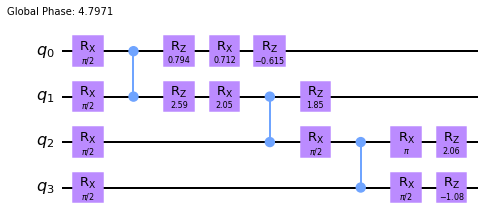

In [ ]:
d = results.decompositions[0]
d.refine()
print(d)
d.circuit.draw(output='mpl')

Note that the `refine` method didn't succeed in eliminating all apparently redundant 1q gates. This seems to generally be the case for more permissieve loss functions (in contrast to ones used in compiling problems, which fix all elements of a unitary matrix up to just a single global phase).

State preparation with the loss function used in this section is in fact available in CPFlow via the following decomposer setup `decomsposer = Synthesize(layer, target_state=GHZ_state)`. For illustration properties, we reconstructed the loss function anew here.

## Relative phase 3q Toffoli gate

Let 
$$U=V D,$$
where $V$ is the unitary matrix of a Toffoli gate and $D$ any unitary diagonal matrix. Then $U$ is called a relative phase Toffoli gate. Relative phase gates can be useful because they sometimes admit decompositions with fewer CNOTs, but can fully replace the original gates in some applications (see [ref](https://arxiv.org/abs/1508.03273).) THe following loss function that corresponds to compiling a relative phase gate
$$L(U)= 1-\frac{\operatorname{Tr}|V^\dagger U|^2}{2^n}.$$
The absolute value squared is taken element-wise. For unitary matrices $V, U$ this loss function reaches the minimum when $V^\dagger U$ is diagonal.

We now construct a loss function corresponding to the relative phase 3q Toffoli gate.

In [ ]:
# Defining 3q Toffoli unitary
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
u_toff3 = Operator(qc.reverse_bits()).data

# Defining custom loss
custom_loss_func = lambda u: 1-(jnp.abs(u_toff3.conj()*u)**2).sum()/2**3

The synthesis routine is setup and initiated as usual (we anticipate that the best possible decomposition contains 3 CZ gates and stop the synthesis when it is reached).

In [ ]:
layer = [[0, 1], [1, 2], [0, 2]] # Fully connected topology.
decomposer = Synthesize(layer, unitary_loss_func=custom_loss_func, label='relative_toff3_connected')
options = AdaptiveOptions(
    min_num_cp_gates=0,
    max_num_cp_gates=10,
    target_num_cz_gates=3,
    stop_if_target_reached=True
)
results = decomposer.adaptive(options)


Starting decomposition routine with the following options:

 AdaptiveOptions(num_samples=100, method='adam', learning_rate=0.1, num_gd_iterations=2000, cp_distribution='uniform', entry_loss=0.001, target_loss=1e-06, threshold_cp=0.2, learning_rate_at_verification=0.01, num_gd_iterations_at_verification=5000, random_seed=0, rotation_gates='xyz', min_num_cp_gates=0, max_num_cp_gates=10, r_mean=0.00055, r_variance=0.5, max_evals=100, target_num_cz_gates=3, stop_if_target_reached=True, keep_logs=False)


Evaluations:   0%|          | 0/100 [00:00<?, ?it/s]


------------------------------------------
iteration 0/100

num_cp_gates: 4, r: 0.0005576462703701775
score: inf, cz counts of prospective results: []

Found no decompositions potentially improving the current best count 14.

------------------------------------------
iteration 1/100

num_cp_gates: 4, r: 0.0004645703038510526
score: inf, cz counts of prospective results: []

Found no decompositions potentially improving the current best count 14.

------------------------------------------
iteration 2/100

num_cp_gates: 4, r: 0.0006478863656424135
score: inf, cz counts of prospective results: []

Found no decompositions potentially improving the current best count 14.

------------------------------------------
iteration 3/100

num_cp_gates: 1, r: 0.002117336240028973
score: inf, cz counts of prospective results: []

Found no decompositions potentially improving the current best count 14.

------------------------------------------
iteration 4/100

num_cp_gates: 9, r: 0.00096986471722

A decomposition with 3 CZ gates was found during the first 4 trials. Here is the result.

< relative_toff3_connected| Clifford+T | loss: 0.0  | CZ count: 3 | CZ depth: 3  | T count: 4 | T depth: 4 >


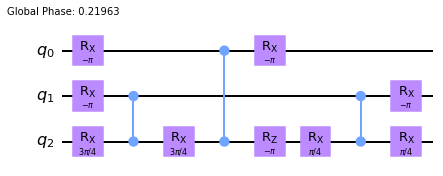

In [ ]:
d = results.decompositions[-1]
d.refine()
print(d)
d.circuit.draw(output='mpl')

# Extra features

## Combining static and adaptive synthesis

In our previous examples ostrations we either used static or adaptive synthesis. The two can be mixed together. A common use case is to first find good hyperparameters with the adaptive routine and then run additional static rounds to generate more/better decompositions. Let us reconsider the first example from this tutorial, 3q Toffoli gate on the chain topology. We will first run 50 hyperparameter evaluations.

In [ ]:
# Define the target unitary
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
u_toff3 = Operator(qc.reverse_bits()).data

# Setup and run the decomposer.
layer = [[0, 1], [1, 2]] # Linear layer
decomposer = Synthesize(layer, target_unitary=u_toff3, label='toff3_chain')
options = AdaptiveOptions(
    min_num_cp_gates=10,
    max_num_cp_gates=20,
    max_evals=50
)

### Uncomment the next line if you want to reproduce results (takes about an hour in Colab). 
### Otherwise skip, the precomputed results will be loaded below.

# results = decomposer.adaptive(options) 

Let us look at the trials and determine the best hyperparameters found so far.

best hyperparameters: number of cp gates=14, r=0.0004645703038510526


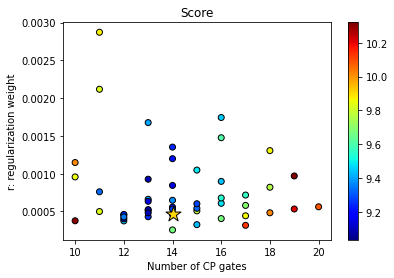

In [ ]:
### Comment out the next line to use local results.
!wget -q -O results/toff3_chain https://github.com/idnm/cpflow/raw/master/tutorial/results/toff3_chain 

results = Results.load('results/toff3_chain')
num_cp_gates_best, r_best = results.best_hyperparameters()[0]
print(f'best hyperparameters: number of cp gates={num_cp_gates_best}, r={r_best}')
results.plot_trials()

Now we can run a static round at the best hyperparameter configuration to generate more/better decompositions. 

In [ ]:
options = StaticOptions(
    num_cp_gates=num_cp_gates_best,
    r = r_best,
    num_samples=50,
    accepted_num_cz_gates=float('inf')  # Let's look at all valid decompositions.
)

### Uncomment the following lines to reproduce results (takes about 15 minutes). 
### Otherwise skip to the loading stage.

# results = decomposer.static(options)
# import tqdm
# for d in tqdm.tqdm(results.decompositions):
#   d.refine()
# results.save()

results = Results.load('results/toff3_chain')
print(f'Found {len(results.decompositions)-4} decompositions in total. Showing the first five.')
results.decompositions[:5]

Found 50 decompositions in total. Showing the first five.


[< toff3_chain| Clifford+T | loss: 2.384185791015625e-07  | CZ count: 8 | CZ depth: 8  | T count: 7 | T depth: 4 >,
 < toff3_chain| Approximate | loss: 0.0  | CZ count: 9 | CZ depth: 9  >,
 < toff3_chain| Approximate | loss: 0.0  | CZ count: 14 | CZ depth: 14  >,
 < toff3_chain| Approximate | loss: 0.0  | CZ count: 15 | CZ depth: 15  >,
 < toff3_chain| Approximate | loss: 1.1920928955078125e-07  | CZ count: 8 | CZ depth: 8  >]

50 decompositoins were found some of which were refined to the Clifford+T circuits.

## Optimizing for CZ depth or other metrics

Because the regularization function in CPFlow penalizes  each CP gate individually, the optimization directly targets only minimization of CZ count. However, circuits with efficient CZ depth and T count or T depth (if applicable) often have small CZ counts as well. This means that generating many decompositions with optimal or near-optimal CZ count and sorting through them can help to find interesting circuits with different metrics. 

As an illustration, we take the circuits generated in the previous section and select those with the shortest CZ depth, T count and T depth.

Total number of Clifford+T decompositoins (out of 50): 4

best CZ count:  < toff3_chain| Clifford+T | loss: 2.384185791015625e-07  | CZ count: 8 | CZ depth: 8  | T count: 7 | T depth: 4 >
best CZ depth:  < toff3_chain| Clifford+T | loss: 2.384185791015625e-07  | CZ count: 8 | CZ depth: 8  | T count: 7 | T depth: 4 >
best T count:  < toff3_chain| Clifford+T | loss: 2.384185791015625e-07  | CZ count: 8 | CZ depth: 8  | T count: 7 | T depth: 4 >
best T depth:  < toff3_chain| Clifford+T | loss: 1.1920928955078125e-07  | CZ count: 8 | CZ depth: 8  | T count: 7 | T depth: 3 >

Best overall decomposition:
< toff3_chain| Clifford+T | loss: 1.1920928955078125e-07  | CZ count: 8 | CZ depth: 8  | T count: 7 | T depth: 3 >


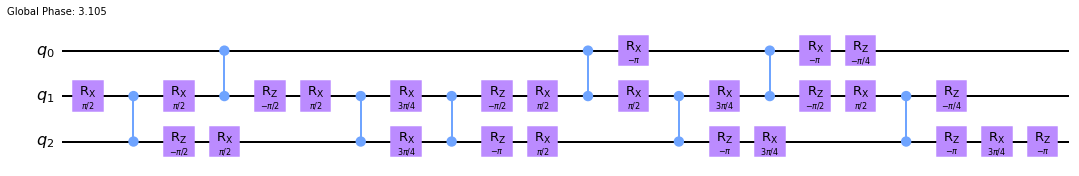

In [ ]:
results = Results.load('results/toff3_chain')
clifford_T_decompositions = [d for d in results.decompositions if d.t_count is not None]

best_cz_count_decomposition = min(clifford_T_decompositions, key=lambda d: d.cz_count)
best_cz_depth_decomposition = min(clifford_T_decompositions, key=lambda d: d.cz_depth)
best_t_count_decomposition = min(clifford_T_decompositions, key=lambda d: d.t_count)
best_t_depth_decomposition = min(clifford_T_decompositions, key=lambda d: d.t_depth)

print(f'Total number of Clifford+T decompositoins (out of 50): {len(clifford_T_decompositions)}\n')

print('best CZ count: ', best_cz_count_decomposition)
print('best CZ depth: ', best_cz_depth_decomposition)
print('best T count: ', best_t_count_decomposition)
print('best T depth: ', best_t_depth_decomposition)

print('\nBest overall decomposition:')
best_decomposition = best_t_depth_decomposition
print(best_decomposition)
qc = best_decomposition.circuit
qc.draw(output='mpl')

Note that the decomposition with the smallest T depth is also the most efficient with respect to the other metrics.

## Tweaking templates

Here we will go a little more in-depth about template structures, what does `layer` variable do exactly, and the role of 1q gates.

Consider the following example.

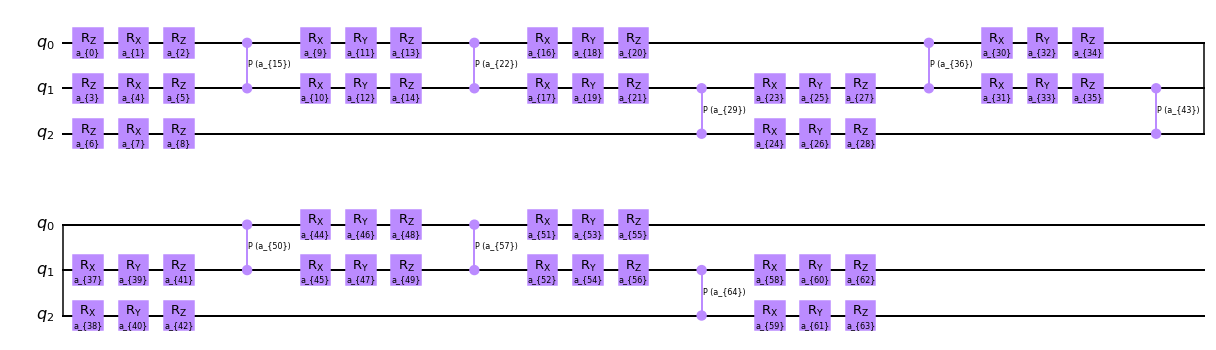

In [ ]:
layer = [[0, 1], [0, 1], [1, 2], [0, 1], [1, 2]]
num_cp_gates = 8

from cpflow.topology import fill_layers
template = Ansatz(3, 'cp', fill_layers(layer, num_cp_gates))
template.circuit().draw(output='mpl')


Layers determine the exact sequence of entangling gates that form the circuit. If an integer number of layers does not fit in the specified number of gates the last layer is truncated. Try changing contents of `layer` and `num_cp_gates` to see exactly how this works.


Another variable at play is what 1q gates are placed in each of the enatangling 2q blocks. A natural choice is to attach an X gate followed by a Z gate after each 2q block, this is sufficient to ensure that the circuit has the maximum expressivity for a chosen template architecture. However, sometimes adding additional 1q gates or changing from XZ pair to, say, XY pair may give different results. This is possible because altering 1q gates (i) changes the loss landscape and (ii) changes the distribution of the initial unitaries obtained by random initialization of angles. Currently, CPFlow by default uses (an overparametrized) sequence XYZ as seen in the circuit above. This can be changed to an arbitrary sequence of 1q gates in the following way

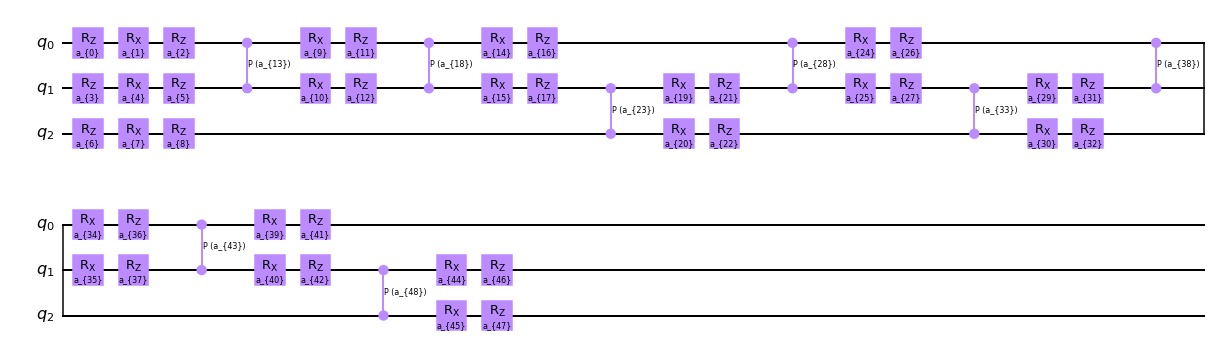

In [ ]:
rotation_gates = 'xz' # Arbitrary string of letters x,y,z is allowed here.
template = Ansatz(3, 'cp', fill_layers(layer, num_cp_gates), rotation_gates=rotation_gates)
template.circuit().draw(output='mpl')

To use non-standard choice of 1q gates in either static or adaptive synthesis provide `rotation_gates` attribute in the corresponding options, e.g. `options = AdaptiveOptions(min_num_cp_gates=0, max_num_cp_gates=10, rotation_gates='xyxz')`.

## Reproducibility

Both static and adaptive synthesis use random subroutines that are fully controlled by the `random_seed` attribute of the corresponding options class (set to zero by default). To change it, simply specify the attribute on instantiation e.g. `options=StaticOptions(..., random_seed=42)` or change it later `options.random_seed=42`.

Decompositions that were generated by CPFlow keep information about their origin. For example, say we have a file storing an interesting decomposition but do not remember the exact setting used to obtain it.

In [ ]:
!wget -q -O results/toff3_chain https://github.com/idnm/cpflow/raw/master/tutorial/results/toff3_chain 
results = Results.load('results/toff3_chain')
d = results.decompositions[0]
print(d)

< toff3_chain| Clifford+T | loss: 2.384185791015625e-07  | CZ count: 8 | CZ depth: 8  | T count: 7 | T depth: 4 >


We can replicate the synthesis procedure that found this decmposition as follows.

In [ ]:
decomposer = d._decomposer
# If we do not change the label here, reproduced decomposition will be attached
# to the existing ones instead of being saved sepately.
decomposer.label = decomposer.label+'_reproduced' 
options = d._static_options

results_reproduced = decomposer.static(options)


Starting decomposition routine with the following options:

 StaticOptions(num_samples=4, method='adam', learning_rate=0.1, num_gd_iterations=2000, cp_distribution='uniform', entry_loss=0.001, target_loss=1e-06, threshold_cp=0.2, learning_rate_at_verification=0.01, num_gd_iterations_at_verification=5000, random_seed=0, rotation_gates='xyz', num_cp_gates=14, r=0.00055, accepted_num_cz_gates=20)

Computing raw results...

Selecting prospective results...

Found 4. Verifying...


  0%|          | 0/4 [00:00<?, ?it/s]


4 successful. cz counts are:
[8, 9, 14, 15]


After refinig, the first of these decompositions indeed appears to be the one that we started with.

In [ ]:
d_reproduced = results_reproduced.decompositions[0]
d_reproduced.refine()
print(d_reproduced)

< toff3_chain_reproduced| Clifford+T | loss: 2.384185791015625e-07  | CZ count: 8 | CZ depth: 8  | T count: 7 | T depth: 4 >


This can be useful to verify the results you already have or to generate more similar decompositions (e.g. by using more samples this time `options.num_samples=100` or a different random seed `options.random_seed=42`).

Unfortunately, reproducibility may be compromised if the version of CPFlow or some of its dependencies changes. The current notebook was created in the following colab environment.

In [ ]:
!python -V
!pip freeze

Python 3.7.13
absl-py==1.0.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.2.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.12.0
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.4.0
audioread==2.1.9
autograd==1.4
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==5.0.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.4
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.10
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2021.10.8
cffi==1.15.0
cftime==1.6.0
chardet==3.0.4
charset-normalizer==2.0.12
chex==0.1.0
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
coverage==3.7.1
coveralls==0.5
cpflow==0.0.4
crcmod==1.7
cryptography==36.0.2
cufflinks==0.17.3
cupy-cuda111==9.4.0
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.28
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.